In [250]:
import yfinance as yf
import numpy as np
import pandas as pd

# Define the ticker symbol
ticker = "AAPL"

In [251]:
data = yf.download(ticker,start='2018-01-01',end='2023-12-31')

[*********************100%***********************]  1 of 1 completed


In [252]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.524345,40.533757,39.818592,40.030320,102223600
2018-01-03,40.517284,41.063069,40.453769,40.587860,118071600
2018-01-04,40.705486,40.808997,40.481999,40.590212,89738400
2018-01-05,41.168934,41.255976,40.710195,40.801943,94640000
2018-01-08,41.016026,41.312441,40.917217,41.016026,82271200


In [253]:
data.to_csv('data.csv', index=False)

In [254]:
data = data.dropna()

In [255]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

In [256]:
data = pd.DataFrame(data_normalized, columns=data.columns)
train_size = int(len(data) * 0.75)
train_data = data[:train_size]
test_data = data[train_size:]

In [257]:
test_data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
1131,0.618495,0.620796,0.604865,0.621048,0.186145
1132,0.631856,0.624830,0.616365,0.613709,0.116789
1133,0.647756,0.640304,0.624093,0.624201,0.122510
1134,0.655978,0.655418,0.649347,0.645913,0.124275
1135,0.676714,0.670049,0.662734,0.657679,0.104868


In [261]:
from stable_baselines3 import PPO

import gym

# Define the trading environment
class TradingEnvironment(gym.Env):
    def __init__(self, data):
        self.data = data
        self.action_space = gym.spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(data.columns),))

    def reset(self):
        self.current_step = 0
        self.account_balance =500 # Initial account balance
        self.shares_held = 0
        self.net_worth = self.account_balance
        self.max_net_worth = self.account_balance

        return self._next_observation()

    def _next_observation(self):
        return self.data.iloc[self.current_step].values

    def step(self, action):
        self._take_action(action)
        self.current_step += 1

        # Ensure we don't exceed the data length
        if self.current_step >= len(self.data):
            done = True
            self.current_step = 0  # Restart the episode
        else:
            done = False

        return self._next_observation(), self._get_reward(), done, {}

    def _take_action(self, action):
        current_price = self.data.iloc[self.current_step].values[0]

        if action == 0:  # Buy
            # Ensure you only buy if you have enough balance
            print("buying", current_price)
            if self.account_balance > current_price:
                self.shares_held += self.account_balance / current_price
                self.account_balance = 0  # Spend all the balance
        elif action == 1:  # Sell
            if self.shares_held > 0:
                self.account_balance += self.shares_held * current_price
                self.shares_held = 0  # Sell all shares

        # Calculate the net worth after the action

        self.net_worth = self.account_balance + self.shares_held * current_price

        # Track the maximum net worth to encourage the model to maximize it
        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

    def _get_reward(self):
        # Reward can be the difference between the current net worth and previous net worth
        return self.net_worth - (self.account_balance + self.shares_held * self.data.iloc[self.current_step].values[0])
# Create the trading environment
env = TradingEnvironment(train_data)

In [272]:
model = PPO("MlpPolicy", env, verbose=1,device="cpu")

# Train the model
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
buying 0.040270515151446445
buying 0.040227246976960646
buying 0.04138050394964099
buying 0.05036146691126547
buying 0.04710347388742292
buying 0.04716116478673732
buying 0.0430959900593999
buying 0.03861271994100193
buying 0.03330782201871349
buying 0.03381224337864275
buying 0.023317759205993688
buying 0.017537028242196412
buying 0.026964955420105574
buying 0.027459933050973634
buying 0.03420497627952654
buying 0.041529055677818866
buying 0.041630365385123796
buying 0.0470003876370273
buying 0.0478833061775476
buying 0.045292358333135996
buying 0.05497578045817092
buying 0.05244275726874359
buying 0.050228132677193615
buying 0.04559628745505084
buying 0.03634715998899571
buying 0.030687701466706963
buying 0.04202118148951495
buying 0.03560905308593598
buying 0.03320625518017173
buying 0.04206451979070169
buying 0.03566686086308532
buying 0.04271587996468701
buying 0.04643584431881742
buying 

J:\Projects\DLproject\ModelTesting\DeepReinforcmentLearning\.venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


buying 0.1280906502617561
buying 0.12422589764573211
buying 0.12812031385625772
buying 0.1417135566904601
buying 0.14039573572621844
buying 0.13898892397847196
buying 0.1403364552883492
buying 0.18136375442087488
buying 0.18100732377551593
buying 0.186651027165658
buying 0.1807400007914967
buying 0.18446765570716456
buying 0.18427471377728566
buying 0.18068050997352458
buying 0.18638375093277276
buying 0.19400259623072252
buying 0.19511667575313912
buying 0.21414190946731732
buying 0.23720681516525438
buying 0.2626926815845016
buying 0.2563361636547755
buying 0.2543458743795628
buying 0.2621135285369272
buying 0.2693613100845866
buying 0.2749454992811896
buying 0.2687822505392802
buying 0.2579890499961535
buying 0.19914012509341167
buying 0.22266192962360126
buying 0.18819816244200432
buying 0.20198362256350916
buying 0.16149057201438316
buying 0.15252851988644806
buying 0.16838332545070256
buying 0.1607611374466742
buying 0.19873825234583747
buying 0.20421669047740876
buying 0.2029810

C:\Users\PKM\AppData\Local\Temp\ipykernel_8712\403372843.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  self.shares_held += self.account_balance / current_price
C:\Users\PKM\AppData\Local\Temp\ipykernel_8712\403372843.py:53: RuntimeWarning: invalid value encountered in scalar multiply
  self.net_worth = self.account_balance + self.shares_held * current_price
C:\Users\PKM\AppData\Local\Temp\ipykernel_8712\403372843.py:61: RuntimeWarning: invalid value encountered in scalar subtract
  return self.net_worth - (self.account_balance + self.shares_held * self.data.iloc[self.current_step].values[0])


buying

KeyboardInterrupt: 

In [263]:
def simulate_trading_strategy(model, data):
    env = TradingEnvironment(data)
    obs = env.reset()

    # Initialize a list to store net worth at each time step
    net_worth_history = [env.net_worth]

    for i in range(len(data)):
        action, _ = model.predict(obs)
        obs, _, done, _ = env.step(action)

        # Append the current net worth to the history
        net_worth_history.append(env.net_worth)

        if done:
            print("Simulation terminated early.")
            break

    return net_worth_history


In [264]:
net_worth = simulate_trading_strategy(model, test_data)
from stable_baselines3 import PPO
from stable_baselines3.common.envs import DummyVecEnv


buying 0.704825869440773
buying 0.7171587250788114
buying 0.7235065940487535
buying 0.7432151890881171
buying 0.7744102572361931
buying 0.7683645875962088
buying 0.7929680263618424
buying 0.7903648297203316
buying 0.811977504943874
buying 0.8404309930938991
buying 0.8486644287989695
buying 0.8462429070640518
buying 0.8064079488522022
buying 0.8213006160794307
buying 0.7539805727065336
buying 0.748229435210537
buying 0.72328695722138
buying 0.7321863160786664
buying 0.7143877853686296
buying 0.7271615041999699
buying 0.7418120940555208
buying 0.6286031011289441
buying 0.6764296046787226
buying 0.6782456057265089
buying 0.6420429301170361
buying 0.6576017075010161
buying 0.6296928700616982
buying 0.6540904168333441
buying 0.6622026735991742
buying 0.6343572306975145
buying 0.701788915778323
buying 0.6942088739215653
buying 0.7059123657941495
buying 0.7026378228688828
buying 0.708034773773951
buying 0.6480010816342354
buying 0.6585525320636223
buying 0.6466064018057531
buying 0.6540045817

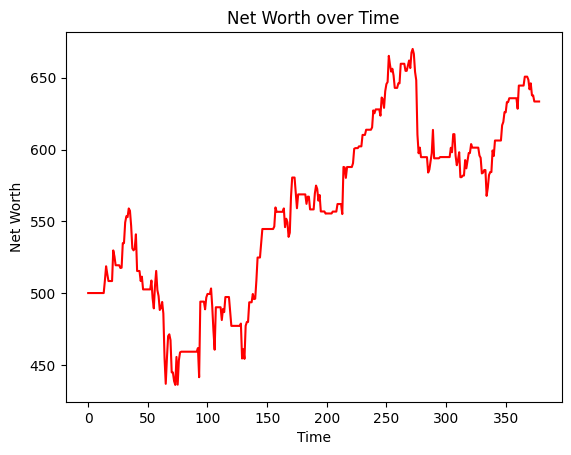

In [295]:
import matplotlib.pyplot as plt


# Plot the net worth over time
plt.plot(net_worth,color='red')
plt.xlabel("Time")
plt.ylabel("Net Worth")
plt.title("Net Worth over Time")
plt.show()

In [296]:
print(net_worth)

[500, np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(508.74886704131876), np.float64(518.6557240659378), np.float64(513.2520140207129), np.float64(508.3628261601863), np.float64(508.3628261601863), np.float64(508.3628261601863), np.float64(508.3628261601863), np.float64(529.7004054223551), np.float64(525.5651378049319), np.float64(519.3624282468234), np.float64(519.3624282468234), np.float64(519.3624282468234), np.float64(519.3624282468234), np.float64(517.4592648116666), np.float64(517.6574382800248), np.float64(534.7867665600191), np.float64(534.7867665600191), np.float64(549.1808629567539), np.float64(553.5268779947043), np.float64(552.8888811150186), np.float64(558.9496051411894), np.float64(557.3547361073964), np.float64(546.8682474333147), np.float64(531.118530832669), np.

In [267]:
def evaluate_model(model, env, num_episodes=10):
    total_rewards = []

    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward

        total_rewards.append(total_reward)

    avg_total_reward = np.mean(total_rewards)
    print(f"Average total reward over {num_episodes} episodes: {avg_total_reward}")



In [316]:
test_env = TradingEnvironment(test_data)
evaluate_model(model, test_env)


buying 0.7900622563813018
buying 0.6122238413438557
buying 0.6590983048015449
buying 0.7068219558565976
buying 0.7210940485315573
buying 0.7683441105995317
buying 0.8040547772751432
buying 0.8702243687433979
buying 0.8163844538360718
buying 0.796295117561687
buying 0.8677220610489864
buying 0.9349356053387083
buying 0.6737516997251336
buying 0.669951767556354
buying 0.713189086293734
buying 0.705789503814086
buying 0.8672348207307898
buying 0.8712541092201394
buying 0.9502412720833948
buying 0.7026378228688828
buying 0.9067751532963839
buying 0.8796509868895561
buying 0.8783183925669811
buying 0.9470703296709975
buying 0.8394623095981175
buying 0.6576017075010161
buying 0.6378743185057982
buying 0.6466064018057531
buying 0.866077823667392
buying 0.8064079488522022
buying 0.6942088739215653
buying 0.6009447562654175
buying 0.9107281486777692
buying 0.8756370280294787
buying 0.796295117561687
buying 0.7026378228688828
buying 0.8756370280294787
buying 0.7225607251063477
buying 0.654513982

In [315]:
from stable_baselines3 import DDPG, A2C, DQN

model = DQN("MlpPolicy", env, device="cuda",verbose=0)


model.learn(total_timesteps=10000,log_interval=4)




J:\Projects\DLproject\ModelTesting\DeepReinforcmentLearning\.venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


buying 0.04723327841088032
buying 0.04593588769218193
buying 0.0501307968162758
buying 0.04920820993858516
buying 0.04710347388742292
buying 0.04716116478673732
buying 0.03861271994100193
buying 0.015605364888977402
buying 0.018341054244148586
buying 0.04233960346295934
buying 0.039560505679900465
buying 0.041630365385123796
buying 0.050995272034446426
buying 0.047666147160274175
buying 0.05244275726874359
buying 0.050228132677193615
buying 0.04568322118866114
buying 0.03634715998899571
buying 0.03320625518017173
buying 0.04034209113754883
buying 0.044004177587828985
buying 0.049938649655674405
buying 0.04935961348593498
buying 0.031816694600858814
buying 0.028820507927227457
buying 0.029645525188330524
buying 0.06124316735099028
buying 0.06701842843211353
buying 0.06597230168291696
buying 0.06533295655036098
buying 0.06533295655036098
buying 0.06438846676640708
buying 0.07283055278236922
buying 0.06619025546946777
buying 0.061758528476267616
buying 0.06142439812181061
buying 0.0599276

In [317]:
model.save("DQN")